### XGBoost with ADSTuner for HPO

* Imblearn for undersampling of negative class
* ADSTuner for HPO
* tuning on more parameters

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb

import ads

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# for undersampling the negative class
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

# my utils.py
from utils import train_encoders, apply_encoders

import pickle

%matplotlib inline

In [2]:
# check the ADS version
print(ads.__version__)

2.5.4


In [3]:
# global constants
SEED = 4321

# number of features (with the two indicator cols)
N_FEATURES = 12

# name of col with label
TARGET = 'SeriousDlqin2yrs'

# cols with missing values
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

# nomi delle due colonne indicator (valgono 1 laddove il dato è inputato)
IND1 = 'isna_mi'
IND2 = 'isna_nod'

ind_col = [IND1, IND2]

COLS_TO_DROP = ['id']

# for undersampling to make the dataset more balanced
# ratio minority samples/majority
RATIO = 1./5.

In [4]:
# full dataset, not undersampled
data_full = pd.read_csv('cs-training-nonull.csv')

# remove unneeded cols
data_full = data_full.drop(COLS_TO_DROP, axis = 1)

In [5]:
cat_cols = ['age','NumberOfTime30-59DaysPastDueNotWorse',
               'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
               'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
               'NumberOfDependents']
num_cols = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', ]

# indicators are not touched

In [6]:
# scaling and label encoding is done on data_full. After we will do resampling
# In this way coding and scaling cover entire range of values, not only for resampled data

# we don't need any scaling (it is ensambles of trees)

In [7]:
# cat cols treatment
# Code categorical columns (only season, weather, year)

# we don't need any pre-processing for cat columns

# so for XGBoost afpret Nan treatment no other pre-processing is needed

In [8]:
# estrae X: matrice features ed y, labels
y_train_full = data_full[TARGET].values
x_train_full = data_full.drop(TARGET, axis = 1).values

assert x_train_full.shape[1] == N_FEATURES

In [9]:
print(f'# of samples in full dataset: {x_train_full.shape[0]}')

# of samples in full dataset: 150000


In [10]:
# do the undersampling of the negative class, using IMblearn
rus = RandomUnderSampler(sampling_strategy=RATIO, random_state=SEED)

x_train, y_train = rus.fit_resample(x_train_full, y_train_full)

print(f'# of samples in resampled dataset: {x_train.shape[0]}')

# check ratio of classes
print(f'# of positive samples: {np.sum(y_train)}')
print(f'# of negative samples: {x_train.shape[0] - np.sum(y_train)}')

# of samples in resampled dataset: 60156
# of positive samples: 10026
# of negative samples: 50130


The resampled dataset (x_train, y_train) will be used for training

### Train the XGBoost Classifier

In [11]:
# parameters for the HPO session with Optuna
FOLDS = 5
SEED = 4321

N_TRIALS = 100
TIME_BUDGET = 7200
STUDY_NAME = "xgb01"

# ranges
LR_LOW = 1e-3
LR_HIGH = 1e-2
DEPTH_LOW = 3
DEPTH_HIGH = 7
N_ITER_LIST = [1000, 1100, 1200, 1300, 1400, 1500]
GAMMA_LOW = 0.1
GAMMA_HIGH = 5
SUBSAMPLE_LOW = 0.1
SUBSAMPLE_HIGH = 1.

In [12]:
#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {
    "n_estimators": CategoricalDistribution(N_ITER_LIST),
    "learning_rate": LogUniformDistribution(low=LR_LOW, high=LR_HIGH),
    "max_depth": IntUniformDistribution(DEPTH_LOW, DEPTH_HIGH),
    "gamma" : LogUniformDistribution(low=GAMMA_LOW, high=GAMMA_HIGH),
    "subsample" : UniformDistribution(low=SUBSAMPLE_LOW, high=SUBSAMPLE_HIGH),
    "tree_method": "gpu_hist"
}

clf = xgb.XGBClassifier()


# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(clf, cv=FOLDS, strategy=params, scoring="roc_auc", study_name=STUDY_NAME, n_jobs=8, random_state=SEED)

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

[I 2022-03-15 14:26:09,984] A new study created in RDB with name: xgb01


In [58]:
# get the status to see if completed
print(f"The tuner status is: {tuner.get_status()}")

print(f"Remaining time is: {round(tuner.time_remaining, 1)} sec.")

The tuner status is: State.COMPLETED
Remaining time is: 0 sec.


In [59]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
    by=["value"], ascending=False
)

result_df.head(10)

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
632,632,0.866993,2022-03-15 16:04:10.960568,2022-03-15 16:05:25.068688,0 days 00:01:14.108120,0.700784,0.008390,4,1500,0.117467,...,roc_auc,0.866174,0.862284,0.866723,0.866212,0.873570,0.070236,0.003321,0.003655,COMPLETE
458,458,0.866990,2022-03-15 15:37:13.006136,2022-03-15 15:38:29.168274,0 days 00:01:16.162138,0.409126,0.007659,4,1500,0.110838,...,roc_auc,0.866183,0.862387,0.866566,0.866149,0.873665,0.379592,0.008393,0.003668,COMPLETE
689,689,0.866976,2022-03-15 16:12:31.022762,2022-03-15 16:13:42.820140,0 days 00:01:11.797378,2.424337,0.008471,4,1500,0.117470,...,roc_auc,0.866212,0.862263,0.866722,0.866140,0.873546,0.115466,0.001781,0.003653,COMPLETE
454,454,0.866960,2022-03-15 15:36:44.578812,2022-03-15 15:37:58.977035,0 days 00:01:14.398223,0.411172,0.008502,4,1500,0.112376,...,roc_auc,0.865887,0.862440,0.866563,0.866322,0.873589,0.106448,0.001292,0.003636,COMPLETE
287,287,0.866925,2022-03-15 15:11:33.397899,2022-03-15 15:12:40.018780,0 days 00:01:06.620881,0.492040,0.008455,4,1400,0.117600,...,roc_auc,0.866046,0.862187,0.866608,0.866027,0.873758,0.113904,0.002878,0.003763,COMPLETE
564,564,0.866919,2022-03-15 15:51:53.259272,2022-03-15 15:53:03.572120,0 days 00:01:10.312848,0.634974,0.007761,4,1500,0.117599,...,roc_auc,0.866076,0.862603,0.866481,0.865988,0.873446,0.720901,0.001339,0.003549,COMPLETE
400,400,0.866918,2022-03-15 15:28:24.922409,2022-03-15 15:29:39.353112,0 days 00:01:14.430703,0.651275,0.008343,4,1500,0.117284,...,roc_auc,0.866261,0.862142,0.866572,0.865895,0.873716,0.080520,0.002193,0.003758,COMPLETE
451,451,0.866914,2022-03-15 15:35:58.992805,2022-03-15 15:37:13.319584,0 days 00:01:14.326779,0.399753,0.008491,4,1500,0.112311,...,roc_auc,0.865881,0.862446,0.866359,0.866245,0.873637,0.207335,0.002506,0.003660,COMPLETE
562,562,0.866910,2022-03-15 15:51:45.318048,2022-03-15 15:52:55.563036,0 days 00:01:10.244988,0.925434,0.007035,4,1500,0.117688,...,roc_auc,0.866013,0.862354,0.866628,0.866057,0.873497,0.569373,0.002501,0.003626,COMPLETE
687,687,0.866904,2022-03-15 16:12:19.303315,2022-03-15 16:13:31.797073,0 days 00:01:12.493758,2.394430,0.008625,4,1500,0.117505,...,roc_auc,0.866063,0.862194,0.866685,0.866116,0.873462,0.155981,0.006770,0.003649,COMPLETE


In [60]:
def show_tuner_results(tuner):

    # to count completed
    result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
        by=["value"], ascending=False
    )

    print("ADSTuner session results:")
    print(f"ADSTuner has launched {tuner.trials.shape[0]} trials")
    print(f"ADSTuner has completed {result_df.shape[0]} trials")
    print()
    print(f"The best trial is the #: {tuner.best_index}")
    print(f"Parameters for the best trial are: {tuner.best_params}")
    print(f"The metric used to optimize is: {tuner.scoring_name}")
    print(f"The best score is: {round(tuner.best_score, 4)}")
    
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has launched 779 trials
ADSTuner has completed 779 trials

The best trial is the #: 632
Parameters for the best trial are: {'gamma': 0.7007836747317996, 'learning_rate': 0.008389825517656139, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.11746700590625371, 'tree_method': 'gpu_hist'}
The metric used to optimize is: roc_auc
The best score is: 0.867


### Train with best params

In [61]:
%%time

clf = xgb.XGBClassifier(**tuner.best_params)

# addestro e valuto su train e su validation set
clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train)],
        eval_metric='auc', verbose=100)

print()

evals_result = clf.evals_result()

[0]	validation_0-auc:0.82164
[100]	validation_0-auc:0.85831
[200]	validation_0-auc:0.86125
[300]	validation_0-auc:0.86423
[400]	validation_0-auc:0.86645
[500]	validation_0-auc:0.86841
[600]	validation_0-auc:0.86985
[700]	validation_0-auc:0.87096
[800]	validation_0-auc:0.87184
[900]	validation_0-auc:0.87264
[1000]	validation_0-auc:0.87343
[1100]	validation_0-auc:0.87408
[1200]	validation_0-auc:0.87467
[1300]	validation_0-auc:0.87522
[1400]	validation_0-auc:0.87574
[1499]	validation_0-auc:0.87637

CPU times: user 2.9 s, sys: 704 ms, total: 3.6 s
Wall time: 3.36 s


#### OK, consider that the slightly higher AUC is due to the fact here we're evaluating also on train data

In [ ]:
def plot_auc(train_hist):
    plt.figure(figsize=(9,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.title('AUC')
    plt.legend(loc='lower right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

In [ ]:
train_hist = evals_result['validation_0']['auc']

plot_auc(train_hist)

In [62]:
# compute accuracy on full dataset
y_pred = clf.predict(x_train_full)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_train_full, predictions)

print("Accuracy on train set: %.2f%%" % (accuracy * 100.0))

Accuracy on train set: 92.68%


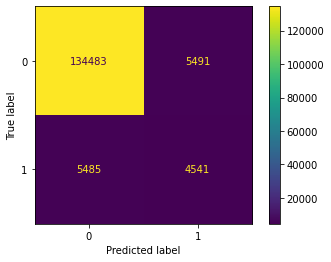

In [74]:
# compute confusion matrix on full dataset
cm = confusion_matrix(y_train_full, predictions)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

In [ ]:
# the number of FN is rather high

### Prediction on the TEST set (for submission to Kaggle)

In [ ]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# inpute missing values, add the two indicator columns
orig_test['isna_mi'] = 0
orig_test.loc[orig_test[COL1_MISSING].isna(), 'isna_mi'] = 1
orig_test.loc[orig_test[COL1_MISSING].isna(), COL1_MISSING] = MONTHLY_INC_MEDIAN

orig_test['isna_nod'] = 0
orig_test.loc[orig_test[COL2_MISSING].isna(), 'isna_nod'] = 1
orig_test.loc[orig_test[COL2_MISSING].isna(), COL2_MISSING] = N_OF_DEP_MODE

In [ ]:
ind_test = orig_test[ind_col].values

In [ ]:
orig_test = orig_test.drop(ind_col, axis = 1)

In [ ]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [ ]:
# aggiungi qui lo scaling !!!
x_test_scaled = scaler.transform(x_test)
# riaggiunge le colonne indicatore
x_test_scaled = np.c_[x_test_scaled, ind_test]

assert x_test_scaled.shape[1] == N_FEATURES

In [ ]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test_scaled)

# y_pred contiene le probabilità
y_pred = y_pred[:, 1]

In [ ]:
# prepara il csv per la submission
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission25.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')

In [ ]:
### Save Modela and scaler

In [ ]:
# save model: uso un formato semplice: pkl
pickle.dump(clf, open("credit-scoring.pkl", "wb"))

In [ ]:
# salvo anche lo scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

### Online predictions

In [ ]:
# reload the model
loaded_model = pickle.load(open("credit-scoring.pkl", "rb"))

In [ ]:
# reload the scaler
loaded_scaler = pickle.load(open("scaler.pkl", "rb"))

In [ ]:
# prepare for online predictions
# input are given as a numpy array, with no missing fields, but we need to add the two indicator columns
x_input = np.array([[1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10]])

In [ ]:
# controlli
assert x_input.shape[1] == 10
# check there are no null
assert np.sum(np.isnan(x_input)) == 0

In [ ]:
# normalize
x_input_scaled = loaded_scaler.transform(x_input)

# add two columns with 0
x_add = np.zeros((x_input.shape[0], 2))
x_input_scaled = np.c_[x_input_scaled, x_add]

In [ ]:
y_pred = loaded_model.predict(x_input_scaled)

In [ ]:
y_pred

In [ ]:
train_df[TARGET].hist();